In [ ]:
##MA6均线策略
###开盘，如果开盘价大于6日均线则开多，低于6日均线则开空
###盘中，在开多的情况下，如果价格回落到6日均线则平多仓，如果价格上穿6日均线则平空仓
###收盘，如果没有触发平仓策略，则收盘平仓。
###开盘价高开/低开因子和开盘价与60日均线的距离因子，_openH,_open2MA60

In [2]:
#导入相关数据库
from KRData.HKData import HKFuture
import talib
import pandas as pd

In [3]:
#连接数据库
hf = HKFuture('KRdata', 'f4615f68-ff8efbf0-5874824e-e1bd1')

In [4]:
#取数据，由20110101-20190401之间HSI的数据
trade_dates=hf.get_main_contract_trade_dates('HSI','20110101','20190401')

In [5]:
#策略逻辑
#构建开仓策略，后面用于循环
def strategy(df:pd.DataFrame):  #传入一个dataframe作为参数
    #设定每日交易时间
    _df = df.between_time('9:15', '16:30')
    #假如该交易日没有交易数据，则输出空值。
    if len(_df) == 0:
        _open = []
        _close = []
        return  _open, _close
    #统计开盘高开/低开点数   
    _openH = _df.iloc[0]['open'] - _df.iloc[0]['last_close']
    #当开盘价大于MA60的时候
    if _df.iloc[0]['gt_ma60']:
        #记录下来open/开仓信息，信息为交易时间，方向，开盘价格
        _open=[_df.iloc[0]['datetime'], '多', _df.iloc[0]['open']]
        #统计开盘价与60日均线的点数差
        _open2Ma60 = _open[2] - _df.iloc[0]['ma60']
        #在这个交易日剩下的序列中构造一个循环判断平仓的信息
        for t, v in _df.iloc[1:].iterrows():
            #在开多仓的情况下，如果K线下穿ma60，则记录平仓信息_close
            if not v['gt_ma60']:
                #记录平仓信息，其中包括在循环中第一个出现小于ma60的时间点，交易方向，开仓价格
                _close=[v['datetime'], '空', v['open']]
                break
        #假如当日行情中没有成交，则在收盘的时候平仓
        else:
            _close=[_df.iloc[-1]['datetime'], '空', _df.iloc[-1]['open']]
    #开盘价小于ma60的情况
    else:
        #记录下来open/开仓信息，信息为交易时间，方向，开盘价格
        _open=[_df.iloc[0]['datetime'], '空', _df.iloc[0]['open']]
        #在这个交易日剩下的序列中构造一个循环来判断平仓信息
        _open2Ma60 = _open[2] - _df.iloc[0]['ma60']
        for t, v in _df.iloc[1:].iterrows():
            #在开空仓的情况下，如果K线上穿ma60，则记录平仓信息_close
            if v['gt_ma60']:
                #记录平仓信息，其中包括在循环中第一个出现大于ma60的时间点，交易方向，开仓价格
                _close=[v['datetime'], '多', v['open']]
                break
        #假如在当日行情中没有成交的话，则在收盘的时候平仓
        else:
            _close=[_df.iloc[-1]['datetime'], '多', _df.iloc[-1]['open']]
    #返回_open和_close值
    
    return   _open, _close, _openH, _open2Ma60

In [6]:
#将策略在每一个合约上循环
#创建一个列表来装上面的计算出来每个合约的结果
ret_list=[]
#设定一个循环来取每个合约的代码和对应的交易时间段
for code,tds in trade_dates.items():
    #打印出来取数据的过程
    print(f'code:{code}    {tds[0]}->{tds[-1]}')
    #取数据的函数
    data=hf.get_bars(code,fields=['datetime','open','high','low','close','trade_date'],start=tds[0],end=tds[-1])
    data_head: pd.DataFrame=hf.get_bars(code,fields=['datetime','open','high','low','close','trade_date'],end=data.iloc[0]['datetime'],bar_counts=60)[:-1]
#     data_head['trade_date'] = data.iloc[0, 'trade_date']
    data = data_head.append(data)
    data['last_close'] = data['close'].shift(1)
    data['ma60']=talib.MA(data['close'],timeperiod=60)
    data['gt_ma60']=data['close']>data['ma60']
    
    #按日期分组函数
    g=data.groupby('trade_date')
    #按日期来执行策略
    ret=g.apply(strategy)
    #将结果组合起来
    ret_list.append(ret)

code:HSI1101    2011-01-03 00:00:00->2011-01-28 00:00:00
code:HSI1102    2011-01-31 00:00:00->2011-02-25 00:00:00
code:HSI1103    2011-02-28 00:00:00->2011-03-30 00:00:00
code:HSI1104    2011-03-31 00:00:00->2011-04-28 00:00:00
code:HSI1105    2011-04-29 00:00:00->2011-05-30 00:00:00
code:HSI1106    2011-05-31 00:00:00->2011-06-29 00:00:00
code:HSI1107    2011-06-30 00:00:00->2011-07-28 00:00:00
code:HSI1108    2011-07-29 00:00:00->2011-08-30 00:00:00
code:HSI1109    2011-08-31 00:00:00->2011-09-30 00:00:00
code:HSI1110    2011-10-03 00:00:00->2011-10-28 00:00:00
code:HSI1111    2011-10-31 00:00:00->2011-11-29 00:00:00
code:HSI1112    2011-11-30 00:00:00->2011-12-29 00:00:00
code:HSI1201    2011-12-30 00:00:00->2012-01-30 00:00:00
code:HSI1202    2012-01-31 00:00:00->2012-02-28 00:00:00
code:HSI1203    2012-02-29 00:00:00->2012-03-29 00:00:00
code:HSI1204    2012-03-30 00:00:00->2012-04-27 00:00:00
code:HSI1205    2012-04-30 00:00:00->2012-05-30 00:00:00
code:HSI1206    2012-05-31 00:0

In [7]:
#输出pnl
#定义一个total_pnl空值，最后接受所有结果
total_pnl = 0
fret_list=[]
for ret in ret_list:
    for trades in ret[1:]:
        _open=trades[0]
        _close=trades[1]
        if _open and _close:
            #开盘价的取值，如果开盘开多单的话，取-_open[2],如果开空单的话，取_open[2]
            _open_values=_open[2] if _open[1]=='空' else -_open[2]
            #平仓的时候取值，如果平仓时开的是多单则取-_close[2],如果开多单的话，取_close[2]
            _close_values=_close[2] if _close[1]=='空' else -_close[2]
            #pnl就是把上面两项加起来，因为其中有一项是取负号的，所以最终结果是赚的点数
            pnl=_open_values+_close_values
            #用list将pnl结果组合起来
            fret_list.append(pnl)
            #用递归方法求出总共赚的点数
            total_pnl+=pnl

In [8]:
#需要计算 
#ALL_Profit总利润,ALL_CNT总交易次数,ALL_Mean总平均盈亏
#这里总利润是total_pnlx50,
#Lose总损失,Lose_CNT损失次数，Lose_Mean平均损失
#Win总盈利,Win_CNT盈利次数，Win_Mean平均盈利
#Win%胜率，Win/Lose盈亏比

In [9]:
#将pnl结果形成一个list，然后统计总的长度，统计+/-总点数和次数

In [10]:
#总计
#总共赚的点
total_pnl
#总利润
ALL_Profit=total_pnl*50
ALL_Profit
#总共交易次数
ALL_CNT=len(fret_list)
ALL_CNT

2027

In [11]:
ALL_Profit

2649400.0

In [14]:
#总平均盈利
Profit_Mean=ALL_Profit/ALL_CNT
Profit_Mean

1307.054760730143

In [15]:
#盈利
#盈利的list
fret_list_pos=[i for i in fret_list if i>0]
#盈利次数
Win_CNT=len(fret_list_pos)
Win_CNT

1080

In [16]:
#盈利利润
s=0
for i in fret_list_pos:
    s+=i
s
#Win总盈利
Win_Profit=s*50
Win_Profit

4678250.0

In [17]:
#亏损
#亏损的list
fret_list_neg=[i for i in fret_list if i<0]
#亏损的次数
Lose_CNT=len(fret_list_neg)
Lose_CNT

928

In [18]:
#亏损
s=0
for i in fret_list_neg:
    s+=i
s
#Lose总损失
TotalLoss=s*50
TotalLoss

-2028850.0

In [19]:
#平均盈利
Win_Mean=Win_Profit/Win_CNT
Win_Mean

4331.712962962963

In [20]:
#平均损失
Win_Loss=TotalLoss/Lose_CNT
Win_Loss

-2186.260775862069

In [21]:
#胜率
WinPer=Win_CNT/ALL_CNT
WinPer

0.5328071040947213

In [22]:
#盈亏比
WinLoss=Win_CNT/Lose_CNT
WinLoss

1.1637931034482758

In [23]:
summary={'总利润':ALL_Profit,
         '总交易次数':ALL_CNT,
         '总平均盈利':Profit_Mean,
         '亏损':TotalLoss,
         '亏损次数':Lose_CNT,
         '平均亏损':Win_Loss,
         '盈利':Win_Profit,
         '盈利次数':Win_CNT,
         '平均盈利':Win_Mean,
         '胜率':WinPer,
         '盈亏比':WinLoss}
print(summary)

{'总利润': 2649400.0, '总交易次数': 2027, '总平均盈利': 1307.054760730143, '亏损': -2028850.0, '亏损次数': 928, '平均亏损': -2186.260775862069, '盈利': 4678250.0, '盈利次数': 1080, '平均盈利': 4331.712962962963, '胜率': 0.5328071040947213, '盈亏比': 1.1637931034482758}


In [ ]:
#优化

In [24]:
#将所有数据拼接在一起
total_ret = pd.concat([ ret.iloc[1:] for ret in ret_list])

In [25]:
#将拼接在一起的数据转成DataFrame
df = total_ret.to_frame()

In [26]:
#从原来的df中分割出来openH，先用df.iloc定位出来全个df，然后用str()访问里面的元素，
#最后将定位的元素赋值给df['openH']
df['openH'] = df.iloc[:,0].str[2]

In [27]:
#同上
df['open2MA60'] = df.iloc[:,0].str[3]

In [28]:
#同上
df['openTime'] = df.iloc[:,0].str[0].str[0]
df['openSide'] = df.iloc[:,0].str[0].str[1]
df['openPrice'] = df.iloc[:,0].str[0].str[2]
df['closeTime'] = df.iloc[:,0].str[1].str[0]
df['closeSide'] = df.iloc[:,0].str[1].str[1]
df['closePrice'] = df.iloc[:,0].str[1].str[2]

In [29]:
#计算每日的pnl
df['pnl'] = (df['closePrice'] - df['openPrice'])*50

In [ ]:
#根据高开/低开的统计

In [30]:
#取出来openH
openH=df.openH

In [31]:
#引入画图函数
%pylab inline

Populating the interactive namespace from numpy and matplotlib


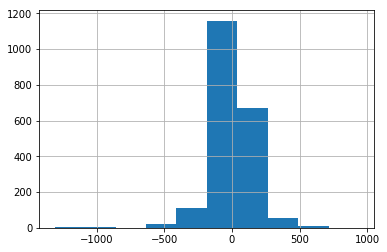

In [32]:
#画出hist图来查看分布
openH.hist()

In [33]:
import numpy as np

In [34]:
#对区间进行划分
np.linspace(-500,500,21)

array([-500., -450., -400., -350., -300., -250., -200., -150., -100.,
        -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,
        400.,  450.,  500.])

In [35]:
#根据划分的区间进行分组
grouped=pd.cut(openH,np.linspace(-500,500,21))

In [36]:
#根据分组的情况对原来的df用groupby函数分组
df_grouped=df.groupby(grouped)

In [37]:
#统计交易次数
df_grouped.count()

,0,openH,open2MA60,openTime,openSide,openPrice,closeTime,closeSide,closePrice,pnl
openH,,,,,,,,,,
"(-500.0, -450.0]",4,4,4,4,4,4,4,4,4,4
"(-450.0, -400.0]",9,9,9,9,9,9,9,9,9,9
"(-400.0, -350.0]",8,8,8,8,8,8,8,8,8,8
"(-350.0, -300.0]",18,18,18,18,18,18,18,18,18,18
"(-300.0, -250.0]",31,31,31,31,31,31,31,31,31,31
"(-250.0, -200.0]",34,34,34,34,34,34,34,34,34,34
"(-200.0, -150.0]",69,69,69,69,69,69,69,69,69,69
"(-150.0, -100.0]",119,119,119,119,119,119,119,119,119,119
"(-100.0, -50.0]",218,218,218,218,218,218,218,218,218,218


In [48]:
#统计总数sum
df_grouped.sum()

,openH,open2MA60,openPrice,closePrice,pnl
openH,,,,,
"(-500.0, -450.0]",-1884.0,-1956.150000,82362.0,82063.0,-14950.0
"(-450.0, -400.0]",-3759.0,-3465.416667,210328.0,209994.0,-16700.0
"(-400.0, -350.0]",-3011.0,-3066.466667,185177.0,185675.0,24900.0
"(-350.0, -300.0]",-5912.0,-5693.100000,420549.0,420773.0,11200.0
"(-300.0, -250.0]",-8284.0,-8340.933333,687576.0,686575.0,-50050.0
"(-250.0, -200.0]",-7516.0,-7112.633333,751759.0,750938.0,-41050.0
"(-200.0, -150.0]",-11920.0,-11985.100000,1597900.0,1597453.0,-22350.0
"(-150.0, -100.0]",-14389.0,-13872.466667,2736002.0,2733411.0,-129550.0
"(-100.0, -50.0]",-15757.0,-14852.200000,5132308.0,5128072.0,-211800.0


In [49]:
#统计mean
df_grouped.mean()

,openH,open2MA60,openPrice,closePrice,pnl
openH,,,,,
"(-500.0, -450.0]",-471.000000,-489.037500,20590.500000,20515.750000,-3737.500000
"(-450.0, -400.0]",-417.666667,-385.046296,23369.777778,23332.666667,-1855.555556
"(-400.0, -350.0]",-376.375000,-383.308333,23147.125000,23209.375000,3112.500000
"(-350.0, -300.0]",-328.444444,-316.283333,23363.833333,23376.277778,622.222222
"(-300.0, -250.0]",-267.225806,-269.062366,22179.870968,22147.580645,-1614.516129
"(-250.0, -200.0]",-221.058824,-209.195098,22110.558824,22086.411765,-1207.352941
"(-200.0, -150.0]",-172.753623,-173.697101,23157.971014,23151.492754,-323.913043
"(-150.0, -100.0]",-120.915966,-116.575350,22991.613445,22969.840336,-1088.655462
"(-100.0, -50.0]",-72.279817,-68.129358,23542.697248,23523.266055,-971.559633


In [50]:
#统计max
df_grouped.max()

,0,openH,open2MA60,openTime,openSide,openPrice,closeTime,closeSide,closePrice,pnl
openH,,,,,,,,,,
"(-500.0, -450.0]","([2014-09-29 09:15:00, 空, 23200.0], [2014-09-2...",-468.0,-452.366667,2014-09-29 09:15:00,空,23200.0,2014-09-29 10:51:00,多,23223.0,1150.0
"(-450.0, -400.0]","([2018-10-11 09:15:00, 空, 25370.0], [2018-10-1...",-401.0,-303.416667,2018-10-11 09:15:00,空,30415.0,2018-10-11 10:15:00,多,30594.0,8950.0
"(-400.0, -350.0]","([2018-10-25 09:15:00, 空, 24775.0], [2018-10-2...",-355.0,-333.283333,2018-10-25 09:15:00,空,31700.0,2018-10-25 10:10:00,多,31921.0,11050.0
"(-350.0, -300.0]","([2018-12-10 09:15:00, 空, 25767.0], [2018-12-1...",-305.0,-222.966667,2018-12-10 09:15:00,空,30554.0,2018-12-10 10:50:00,多,30513.0,11200.0
"(-300.0, -250.0]","([2019-03-08 09:15:00, 空, 28456.0], [2019-03-0...",-250.0,-147.683333,2019-03-08 09:15:00,空,31230.0,2019-03-08 10:11:00,多,31082.0,7300.0
"(-250.0, -200.0]","([2018-12-18 09:15:00, 空, 25881.0], [2018-12-1...",-200.0,-109.500000,2018-12-18 09:15:00,空,26984.0,2018-12-18 09:30:00,多,27128.0,7200.0
"(-200.0, -150.0]","([2019-02-08 09:15:00, 空, 27666.0], [2019-02-0...",-150.0,-79.900000,2019-02-08 09:15:00,空,31705.0,2019-02-08 10:10:00,多,31772.0,7750.0
"(-150.0, -100.0]","([2019-03-28 09:15:00, 空, 28567.0], [2019-03-2...",-100.0,-11.483333,2019-03-28 09:15:00,空,30642.0,2019-03-28 10:01:00,空,30661.0,10450.0
"(-100.0, -50.0]","([2019-03-07 09:15:00, 空, 28930.0], [2019-03-0...",-50.0,69.983333,2019-03-07 09:15:00,空,31407.0,2019-03-07 10:02:00,空,31398.0,8400.0


In [51]:
#统计min
df_grouped.min()

,0,openH,open2MA60,openTime,openSide,openPrice,closeTime,closeSide,closePrice,pnl
openH,,,,,,,,,,
"(-500.0, -450.0]","([2011-08-03 09:15:00, 空, 21934.0], [2011-08-0...",-480.0,-545.483333,2011-08-03 09:15:00,空,16955.0,2011-08-03 10:13:00,多,16859.0,-9750.0
"(-450.0, -400.0]","([2011-10-18 09:15:00, 空, 18370.0], [2011-10-1...",-439.0,-455.700000,2011-10-18 09:15:00,空,18370.0,2011-10-18 10:55:00,多,18259.0,-15850.0
"(-400.0, -350.0]","([2011-06-02 09:15:00, 空, 23137.0], [2011-06-0...",-395.0,-424.616667,2011-06-02 09:15:00,空,18027.0,2011-06-02 10:13:00,多,17927.0,-5000.0
"(-350.0, -300.0]","([2011-01-31 09:45:00, 空, 23280.0], [2011-01-3...",-349.0,-410.366667,2011-01-31 09:45:00,空,18225.0,2011-01-31 10:43:00,多,18353.0,-11200.0
"(-300.0, -250.0]","([2011-02-22 09:45:00, 空, 23196.0], [2011-02-2...",-298.0,-384.300000,2011-02-22 09:45:00,空,17576.0,2011-02-22 11:18:00,多,17474.0,-19050.0
"(-250.0, -200.0]","([2011-03-11 09:15:00, 空, 23415.0], [2011-03-1...",-247.0,-338.650000,2011-03-11 09:15:00,空,16666.0,2011-03-11 09:57:00,多,16773.0,-21750.0
"(-200.0, -150.0]","([2011-03-07 09:15:00, 空, 23152.0], [2011-03-0...",-198.0,-276.666667,2011-03-07 09:15:00,空,17870.0,2011-03-07 09:41:00,多,17888.0,-31950.0
"(-150.0, -100.0]","([2011-01-20 09:45:00, 空, 24254.0], [2011-01-2...",-149.0,-208.633333,2011-01-20 09:45:00,多,17633.0,2011-01-20 11:32:00,多,17646.0,-19500.0
"(-100.0, -50.0]","([2011-01-05 09:45:00, 空, 23604.0], [2011-01-0...",-99.0,-214.833333,2011-01-05 09:45:00,多,18301.0,2011-01-05 10:15:00,多,18325.0,-24300.0


In [ ]:
#根据开盘价与MA60的差值进行统计

In [52]:
#取出来open2MA60
open2MA60=df.open2MA60

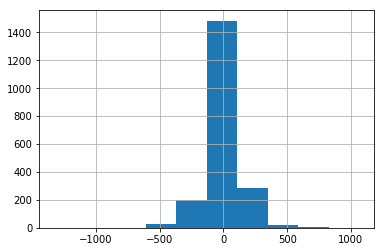

In [53]:
open2MA60.hist()

In [54]:
#对区间进行划分
np.linspace(-500,500,21)

array([-500., -450., -400., -350., -300., -250., -200., -150., -100.,
        -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,
        400.,  450.,  500.])

In [55]:
#根据划分的区间进行分组
grouped2=pd.cut(open2MA60,np.linspace(-500,500,21))

In [56]:
#根据分组的情况对原来的df用groupby函数进行分组
df_grouped2=df.groupby(grouped2)

In [43]:
#统计交易次数
df_grouped2.count()

,0,openH,open2MA60,openTime,openSide,openPrice,closeTime,closeSide,closePrice,pnl
open2MA60,,,,,,,,,,
"(-500.0, -450.0]",5,5,5,5,5,5,5,5,5,5
"(-450.0, -400.0]",6,6,6,6,6,6,6,6,6,6
"(-400.0, -350.0]",14,14,14,14,14,14,14,14,14,14
"(-350.0, -300.0]",16,16,16,16,16,16,16,16,16,16
"(-300.0, -250.0]",22,22,22,22,22,22,22,22,22,22
"(-250.0, -200.0]",37,37,37,37,37,37,37,37,37,37
"(-200.0, -150.0]",74,74,74,74,74,74,74,74,74,74
"(-150.0, -100.0]",121,121,121,121,121,121,121,121,121,121
"(-100.0, -50.0]",231,231,231,231,231,231,231,231,231,231


In [44]:
#统计总数sum
df_grouped2.sum()

,openH,open2MA60,openPrice,closePrice,pnl
open2MA60,,,,,
"(-500.0, -450.0]",-2382.0,-2364.383333,104330.0,104340.0,500.0
"(-450.0, -400.0]",-2489.0,-2532.600000,149338.0,149102.0,-11800.0
"(-400.0, -350.0]",-5160.0,-5281.533333,322351.0,322884.0,26650.0
"(-350.0, -300.0]",-4817.0,-5159.550000,354061.0,354100.0,1950.0
"(-300.0, -250.0]",-6013.0,-6234.683333,496606.0,495402.0,-60200.0
"(-250.0, -200.0]",-8237.0,-8349.683333,831085.0,829638.0,-72350.0
"(-200.0, -150.0]",-12742.0,-12842.933333,1696039.0,1696129.0,4500.0
"(-150.0, -100.0]",-13973.0,-14942.266667,2789250.0,2786878.0,-118600.0
"(-100.0, -50.0]",-14831.0,-16501.000000,5464609.0,5461806.0,-140150.0


In [45]:
#统计mean
df_grouped2.mean()

,openH,open2MA60,openPrice,closePrice,pnl
open2MA60,,,,,
"(-500.0, -450.0]",-476.400000,-472.876667,20866.000000,20868.000000,100.000000
"(-450.0, -400.0]",-414.833333,-422.100000,24889.666667,24850.333333,-1966.666667
"(-400.0, -350.0]",-368.571429,-377.252381,23025.071429,23063.142857,1903.571429
"(-350.0, -300.0]",-301.062500,-322.471875,22128.812500,22131.250000,121.875000
"(-300.0, -250.0]",-273.318182,-283.394697,22573.000000,22518.272727,-2736.363636
"(-250.0, -200.0]",-222.621622,-225.667117,22461.756757,22422.648649,-1955.405405
"(-200.0, -150.0]",-172.189189,-173.553153,22919.445946,22920.662162,60.810811
"(-150.0, -100.0]",-115.479339,-123.489807,23051.652893,23032.049587,-980.165289
"(-100.0, -50.0]",-64.203463,-71.432900,23656.316017,23644.181818,-606.709957


In [46]:
#统计max
df_grouped2.max()

,0,openH,open2MA60,openTime,openSide,openPrice,closeTime,closeSide,closePrice,pnl
open2MA60,,,,,,,,,,
"(-500.0, -450.0]","([2016-06-24 09:15:00, 空, 20553.0], [2016-06-2...",-439.0,-452.366667,2016-06-24 09:15:00,空,23200.0,2016-06-24 09:44:00,多,23223.0,16200.0
"(-450.0, -400.0]","([2018-10-11 09:15:00, 空, 25370.0], [2018-10-1...",-339.0,-407.116667,2018-10-11 09:15:00,空,31700.0,2018-10-11 10:15:00,多,31921.0,11050.0
"(-400.0, -350.0]","([2018-12-05 09:15:00, 空, 26788.0], [2018-12-0...",-283.0,-357.200000,2018-12-05 09:15:00,空,30415.0,2018-12-05 10:03:00,多,30594.0,8950.0
"(-350.0, -300.0]","([2019-03-08 09:15:00, 空, 28456.0], [2019-03-0...",-203.0,-303.416667,2019-03-08 09:15:00,空,30554.0,2019-03-08 10:11:00,多,30513.0,9450.0
"(-300.0, -250.0]","([2018-12-06 09:15:00, 空, 26494.0], [2018-12-0...",-184.0,-256.483333,2018-12-06 09:15:00,空,30450.0,2018-12-06 10:22:00,多,30522.0,11200.0
"(-250.0, -200.0]","([2019-02-08 09:15:00, 空, 27666.0], [2019-02-0...",-97.0,-200.200000,2019-02-08 09:15:00,空,31230.0,2019-02-08 10:10:00,多,31082.0,7200.0
"(-200.0, -150.0]","([2019-03-28 09:15:00, 空, 28567.0], [2019-03-2...",-109.0,-151.333333,2019-03-28 09:15:00,空,31705.0,2019-03-28 10:01:00,多,31772.0,7750.0
"(-150.0, -100.0]","([2019-03-11 09:15:00, 空, 28089.0], [2019-03-1...",-6.0,-100.000000,2019-03-11 09:15:00,空,31399.0,2019-03-11 09:19:00,空,31391.0,10450.0
"(-100.0, -50.0]","([2019-03-20 09:15:00, 空, 29387.0], [2019-03-2...",124.0,-50.283333,2019-03-20 09:15:00,空,32837.0,2019-03-20 10:25:00,空,32868.0,9050.0


In [47]:
#统计min
df_grouped2.min()

,0,openH,open2MA60,openTime,openSide,openPrice,closeTime,closeSide,closePrice,pnl
open2MA60,,,,,,,,,,
"(-500.0, -450.0]","([2011-08-03 09:15:00, 空, 21934.0], [2011-08-0...",-527.0,-498.016667,2011-08-03 09:15:00,空,18370.0,2011-08-03 10:13:00,多,18259.0,-9750.0
"(-450.0, -400.0]","([2014-02-04 09:15:00, 空, 21475.0], [2014-02-0...",-537.0,-445.583333,2014-02-04 09:15:00,空,19550.0,2014-02-04 10:12:00,多,19560.0,-15850.0
"(-400.0, -350.0]","([2011-03-17 09:15:00, 空, 22277.0], [2011-03-1...",-426.0,-398.566667,2011-03-17 09:15:00,空,18027.0,2011-03-17 10:06:00,多,17927.0,-8650.0
"(-350.0, -300.0]","([2011-01-31 09:45:00, 空, 23280.0], [2011-01-3...",-425.0,-349.783333,2011-01-31 09:45:00,空,17576.0,2011-01-31 10:43:00,多,17474.0,-7550.0
"(-300.0, -250.0]","([2011-02-22 09:45:00, 空, 23196.0], [2011-02-2...",-337.0,-299.666667,2011-02-22 09:45:00,空,17918.0,2011-02-22 11:18:00,多,17862.0,-19050.0
"(-250.0, -200.0]","([2011-05-06 09:15:00, 空, 22832.0], [2011-05-0...",-343.0,-247.900000,2011-05-06 09:15:00,空,17877.0,2011-05-06 09:53:00,多,17866.0,-21750.0
"(-200.0, -150.0]","([2011-03-07 09:15:00, 空, 23152.0], [2011-03-0...",-284.0,-198.983333,2011-03-07 09:15:00,空,16666.0,2011-03-07 09:41:00,多,16773.0,-12650.0
"(-150.0, -100.0]","([2011-01-20 09:45:00, 空, 24254.0], [2011-01-2...",-255.0,-148.766667,2011-01-20 09:45:00,多,17870.0,2011-01-20 11:32:00,多,17888.0,-31950.0
"(-100.0, -50.0]","([2011-01-10 09:45:00, 空, 23657.0], [2011-01-1...",-163.0,-99.766667,2011-01-10 09:45:00,多,18100.0,2011-01-10 09:48:00,多,18091.0,-19500.0
